XGBoost Test Doğruluk: % 85.65
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       549
           1       0.76      0.65      0.70       549
           2       0.87      0.82      0.84       549
           3       0.94      0.97      0.95       550
           4       0.88      0.94      0.91       550
           5       0.82      0.88      0.85       549
           6       0.94      0.96      0.95       550

    accuracy                           0.86      3846
   macro avg       0.85      0.86      0.85      3846
weighted avg       0.85      0.86      0.85      3846



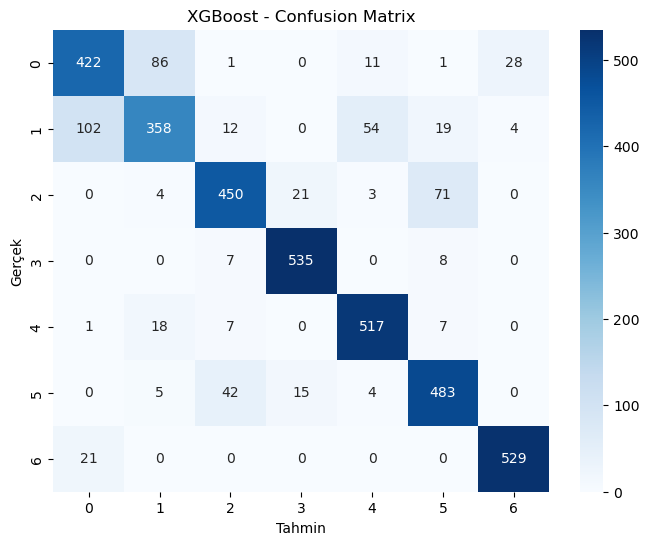

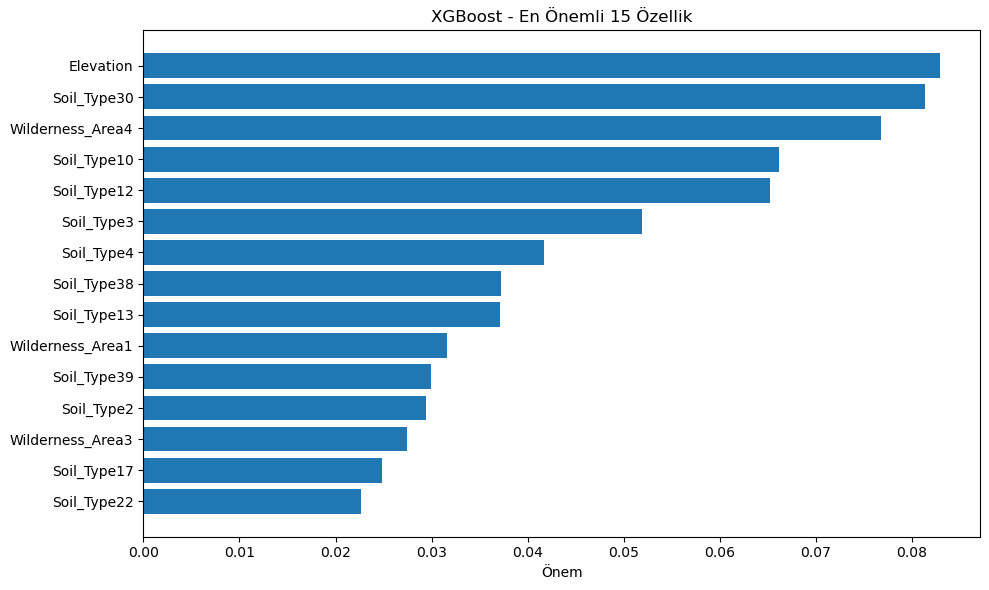

In [5]:
# Forest Cover Type - DENGELİ XGBOOST

import pandas as pd  # Pandas: tablo (DataFrame) işlemleri, veri okuma ve yönetimi için
import numpy as np   # Numpy: sayısal hesaplamalar, array işlemleri için
from sklearn.model_selection import train_test_split  # Eğitim/test ayrımı için fonksiyon
from xgboost import XGBClassifier                    # XGBoost algoritması için, Boosting’in kralı!
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Model değerlendirme metrikleri
import matplotlib.pyplot as plt   # Grafik çizimi için temel kütüphane
import seaborn as sns            # Heatmap gibi gelişmiş grafikler için
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("covtype.csv")  # Veri setini CSV’den oku, pandas DataFrame’e ata

n = df["Cover_Type"].value_counts().min()
# Her sınıfın örnek sayısına bakar, en az olanın adedini alır.
# Amaç: Tüm sınıflardan eşit örnekle dengeli veri seti oluşturmak.

df_dengeli = df.groupby("Cover_Type", group_keys=False).apply(lambda x: x.sample(n=n, random_state=42))
# Veriyi 'Cover_Type' değerine göre gruplar, her gruptan n tane satırı rastgele seçer.
# Sonuç: Tam dengeli (balanced) veri seti!
# random_state=42 ile hep aynı satırlar seçilsin, tekrar çalışınca sonuç değişmesin.

X = df_dengeli.drop("Cover_Type", axis=1)
# Tahmin etmeye çalıştığımız sütunu (target/etiket) çıkartıyoruz, geriye sadece giriş özellikleri (features) kalıyor.

y = df_dengeli["Cover_Type"] - 1
# Sınıfları 1’den başlatmak yerine 0’dan başlatıyoruz, çünkü XGBoost ve sklearn algoritmaları 0 tabanlı etiket ister.

X_egitim, X_test, y_egitim, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Veriyi %80 eğitim, %20 test olacak şekilde böldük.
# stratify=y ile eğitim ve testteki sınıf oranları eşit tutuluyor (dengesizlik olmasın diye).
# random_state=42: Sonuçların her zaman aynı olması için (bilimsel tekrar).

xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# XGBoost modeli kuruyoruz.
# n_estimators=100: 100 tane “ağaç” ile boosting yapılacak.
# random_state=42: Aynı modelin tekrar üretilebilir olmasını sağlar.
# use_label_encoder=False: Uyarı mesajlarını engellemek için (yeni XGBoost’ta öneriliyor).
# eval_metric='mlogloss': Çoklu sınıflar için uygun olan loss fonksiyonu (çoklu sınıflamada default öneri).

xgb.fit(X_egitim, y_egitim)
# Modeli eğitim verisinde eğitiyoruz. XGBoost, her iterasyonda önceki hataları düzelten yeni ağaçlar ekler.
# Boosting: Zayıf modelleri “güçlü” hale getirerek çalışır.

y_tahmin = xgb.predict(X_test)
# Test seti üzerinde tahmin yapılıyor. Artık modelin başarısına bakacağız.

dogruluk = accuracy_score(y_test, y_tahmin)
# Doğruluk oranı: Tüm tahminlerin yüzde kaçını doğru bildi?

cm = confusion_matrix(y_test, y_tahmin)
# Karışıklık matrisi: Hangi gerçek sınıf ne kadar doğru/yanlış tahmin edildi? (satır=gerçek, sütun=tahmin)

print("XGBoost Test Doğruluk: %", round(dogruluk*100,2))
# Doğruluk oranını yüzdeyle ekrana yaz.

print(classification_report(y_test, y_tahmin, zero_division=0))
# Her bir sınıf için precision, recall, f1-score ve support metrikleri detaylı şekilde basılır.
# zero_division=0: Bazı sınıflarda hiç tahmin yapılmazsa kod hata vermesin diye.

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
# confusion_matrix’i görsel olarak heatmap şeklinde çiz.
# annot=True: Karelerin içinde sayı yazılsın.
# fmt='d': Tam sayı formatı.
# cmap="Blues": Renk skalası. Koyu mavi = yüksek sayı.

plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
# Grafiğe başlık ve eksen adları ekleniyor, ardından gösteriliyor.

if hasattr(xgb, "feature_importances_"):
    # XGBoost, karar ağaçları kullandığı için feature_importances_ özniteliği var.
    importances = xgb.feature_importances_
    # Hangi özellik/model girdisi, sonucu daha çok etkiliyor? Bunu çıkarıyoruz.
    sorted_idx = np.argsort(importances)[::-1][:15]
    # En yüksekten düşüğe sıralayıp, ilk 15 tanesini al.
    plt.figure(figsize=(10,6))
    plt.barh(X.columns[sorted_idx][::-1], importances[sorted_idx][::-1])
    # Yatay çubuk grafik: En önemli 15 özelliği (önemli yukarıda olacak şekilde) gösterir.
    plt.xlabel("Önem")
    plt.title("XGBoost - En Önemli 15 Özellik")
    plt.tight_layout()
    plt.show()
    # Grafik başlığı ve eksen adı ekle, sıkıştır ve göster.

# Notlar:
# XGBoost = “Extreme Gradient Boosting”; klasik AdaBoost’tan çok daha hızlı ve esnek, overfitting’e dayanıklı.
# Özellikle büyük veri setlerinde ve çoklu sınıflandırmada sıkça tercih edilir.
# RandomForest ile Boosting modellerinin mantığı farklı; XGBoost, önceki hatalara ağırlık verip düzelte düzelte ilerler.
